# Economic Anslysis
![Alt text](images.jpeg)

In [2]:
! pip install fredapi 

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px

plt.style.use('fivethirtyeight')
pd.set_option('display.max_columns',500)
color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]

from fredapi import Fred
fred_key = '11ba131eff28465a790fa43efafb10cd'


# 1.Create The Ferd Object


In [4]:
fred = Fred(api_key=fred_key)


# 2. Search For Economic Data

In [5]:
sp_search = fred.search('S&P', order_by ='popularity')

In [6]:
sp_search.head()

,id,realtime_start,realtime_end,title,observation_start,observation_end,frequency,frequency_short,units,units_short,seasonal_adjustment,seasonal_adjustment_short,last_updated,popularity,notes
series id,,,,,,,,,,,,,,,
BAMLH0A0HYM2,BAMLH0A0HYM2,2023-01-23,2023-01-23,ICE BofA US High Yield Index Option-Adjusted S...,1996-12-31,2023-01-20,"Daily, Close",D,Percent,%,Not Seasonally Adjusted,NSA,2023-01-23 09:24:05-06:00,94,The ICE BofA Option-Adjusted Spreads (OASs) ar...
CSUSHPINSA,CSUSHPINSA,2023-01-23,2023-01-23,S&P/Case-Shiller U.S. National Home Price Index,1987-01-01,2022-10-01,Monthly,M,Index Jan 2000=100,Index Jan 2000=100,Not Seasonally Adjusted,NSA,2022-12-27 08:02:01-06:00,90,"For more information regarding the index, plea..."
SP500,SP500,2023-01-23,2023-01-23,S&P 500,2013-01-22,2023-01-20,"Daily, Close",D,Index,Index,Not Seasonally Adjusted,NSA,2023-01-20 19:10:57-06:00,84,The observations for the S&P 500 represent the...
BAMLH0A0HYM2EY,BAMLH0A0HYM2EY,2023-01-23,2023-01-23,ICE BofA US High Yield Index Effective Yield,1996-12-31,2023-01-20,"Daily, Close",D,Percent,%,Not Seasonally Adjusted,NSA,2023-01-23 09:24:10-06:00,84,This data represents the effective yield of th...
CSUSHPISA,CSUSHPISA,2023-01-23,2023-01-23,S&P/Case-Shiller U.S. National Home Price Index,1987-01-01,2022-10-01,Monthly,M,Index Jan 2000=100,Index Jan 2000=100,Seasonally Adjusted,SA,2022-12-27 08:02:04-06:00,81,"For more information regarding the index, plea..."


# Pull Raw Data & Plot

In [7]:
sp500 = fred.get_series(series_id='Sp500')

<AxesSubplot: title={'center': 'S&p 500'}>

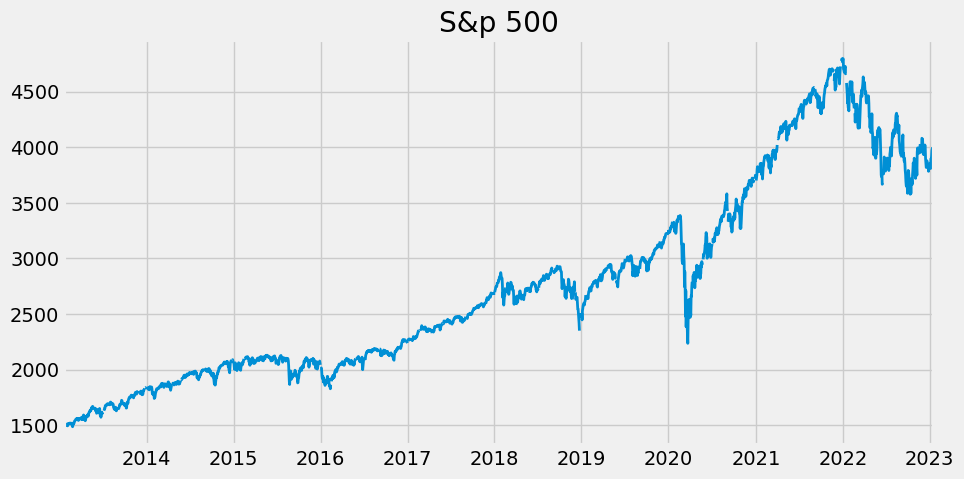

In [8]:
sp500.plot(figsize=(10,5), title ='S&p 500', lw=2)

# 4. Pull and Join Multiple data Series

In [25]:
unemp_df = fred.search('unemployment rate state', filter=('frequency','Monthly'))
unemp_df = unemp_df.query('seasonal_adjustment == "Seasonally Adjusted" and units == "Percent"')
unemp_df = unemp_df.loc[unemp_df['title'].str.contains('Unemployment Rate')]

In [14]:

all_results = []

for myid in unemp_df.index:
    results = fred.get_series(myid)
    results = results.to_frame(name=myid)
    all_results.append(results)
    #time.sleep(0.1) # Don't request to fast and get blocked
uemp_results = pd.concat(all_results, axis=1)

In [26]:
cols_to_drop = []
for i in uemp_results:
    if len(i) > 4:
        cols_to_drop.append(i)
uemp_results = uemp_results.drop(columns = cols_to_drop, axis=1)

In [27]:
uemp_states = uemp_results.copy()  #.drop('UNRATE', axis=1)
uemp_states = uemp_states.dropna()
id_to_state = unemp_df['title'].str.replace('Unemployment Rate in ','').to_dict()
uemp_states.columns = [id_to_state[c] for c in uemp_states.columns]

In [28]:
#plot state unemployement Rate
px.line(uemp_states)


## Pull April 2020 Unemployementt Rate Per State

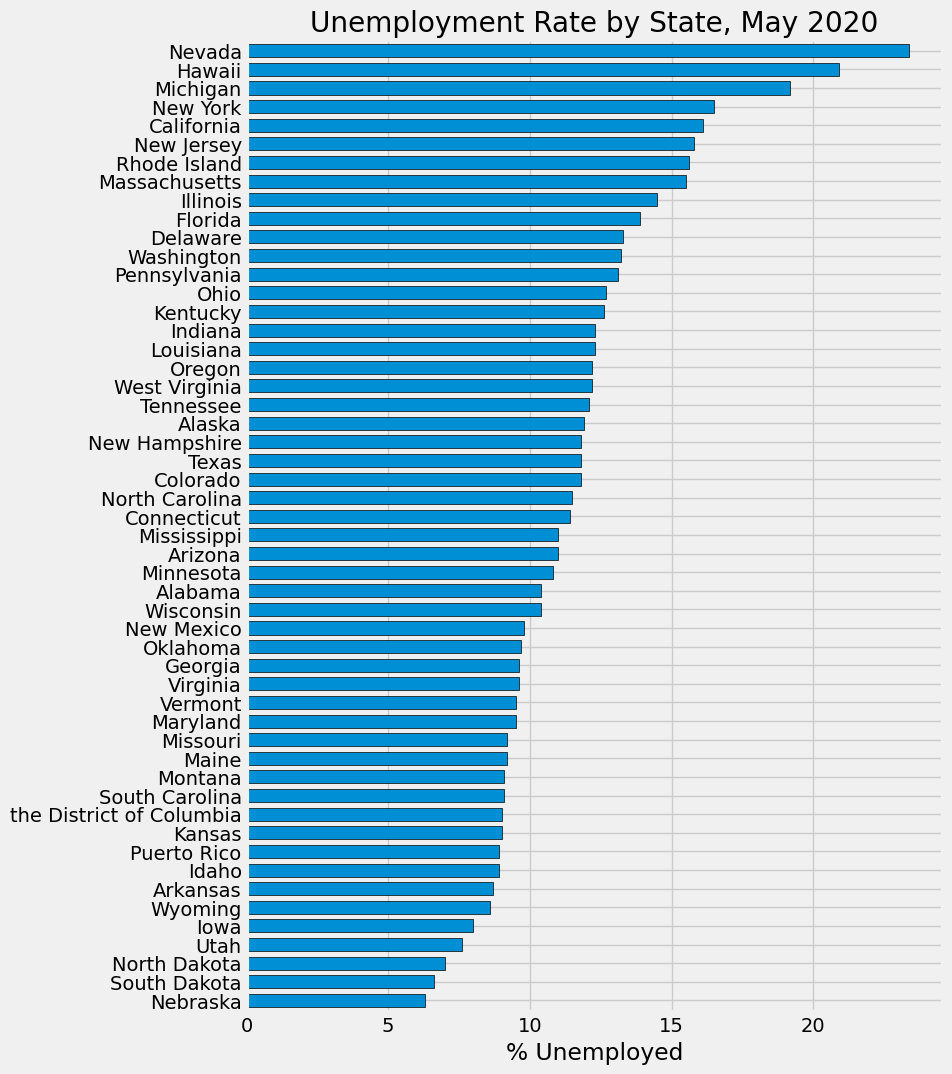

In [29]:
ax = uemp_states.loc[uemp_states.index == '2020-05-01'].T \
    .sort_values('2020-05-01') \
    .plot(kind='barh', figsize=(8, 12), width=0.7, edgecolor='black',
          title='Unemployment Rate by State, May 2020')
ax.legend().remove() 
ax.set_xlabel('% Unemployed')
plt.show()

# Participation Rate

In [30]:
part_df = fred.search('participation rate state', filter=('frequency','Monthly'))
part_df = part_df.query('seasonal_adjustment == "Seasonally Adjusted" and units == "Percent"')

In [36]:
part_id_to_state = part_df['title'].str.replace('Labor Force Participation Rate for ','').to_dict()
all_results = []
for myid in part_df.index:
    results = fred.get_series(myid)
    results = results.to_frame(name=myid)
    all_results.append(results)
    #time.sleep(0.1) # Don't request to fast and get blocked
part_states = pd.concat(all_results, axis=1)
part_states.columns = [part_id_to_state[c] for c in part_states.columns]

# Plot Unemployement vs Participation

In [38]:
# Fix DC
uemp_states = uemp_states.rename(columns={'the District of Columbia':'District Of Columbia'})

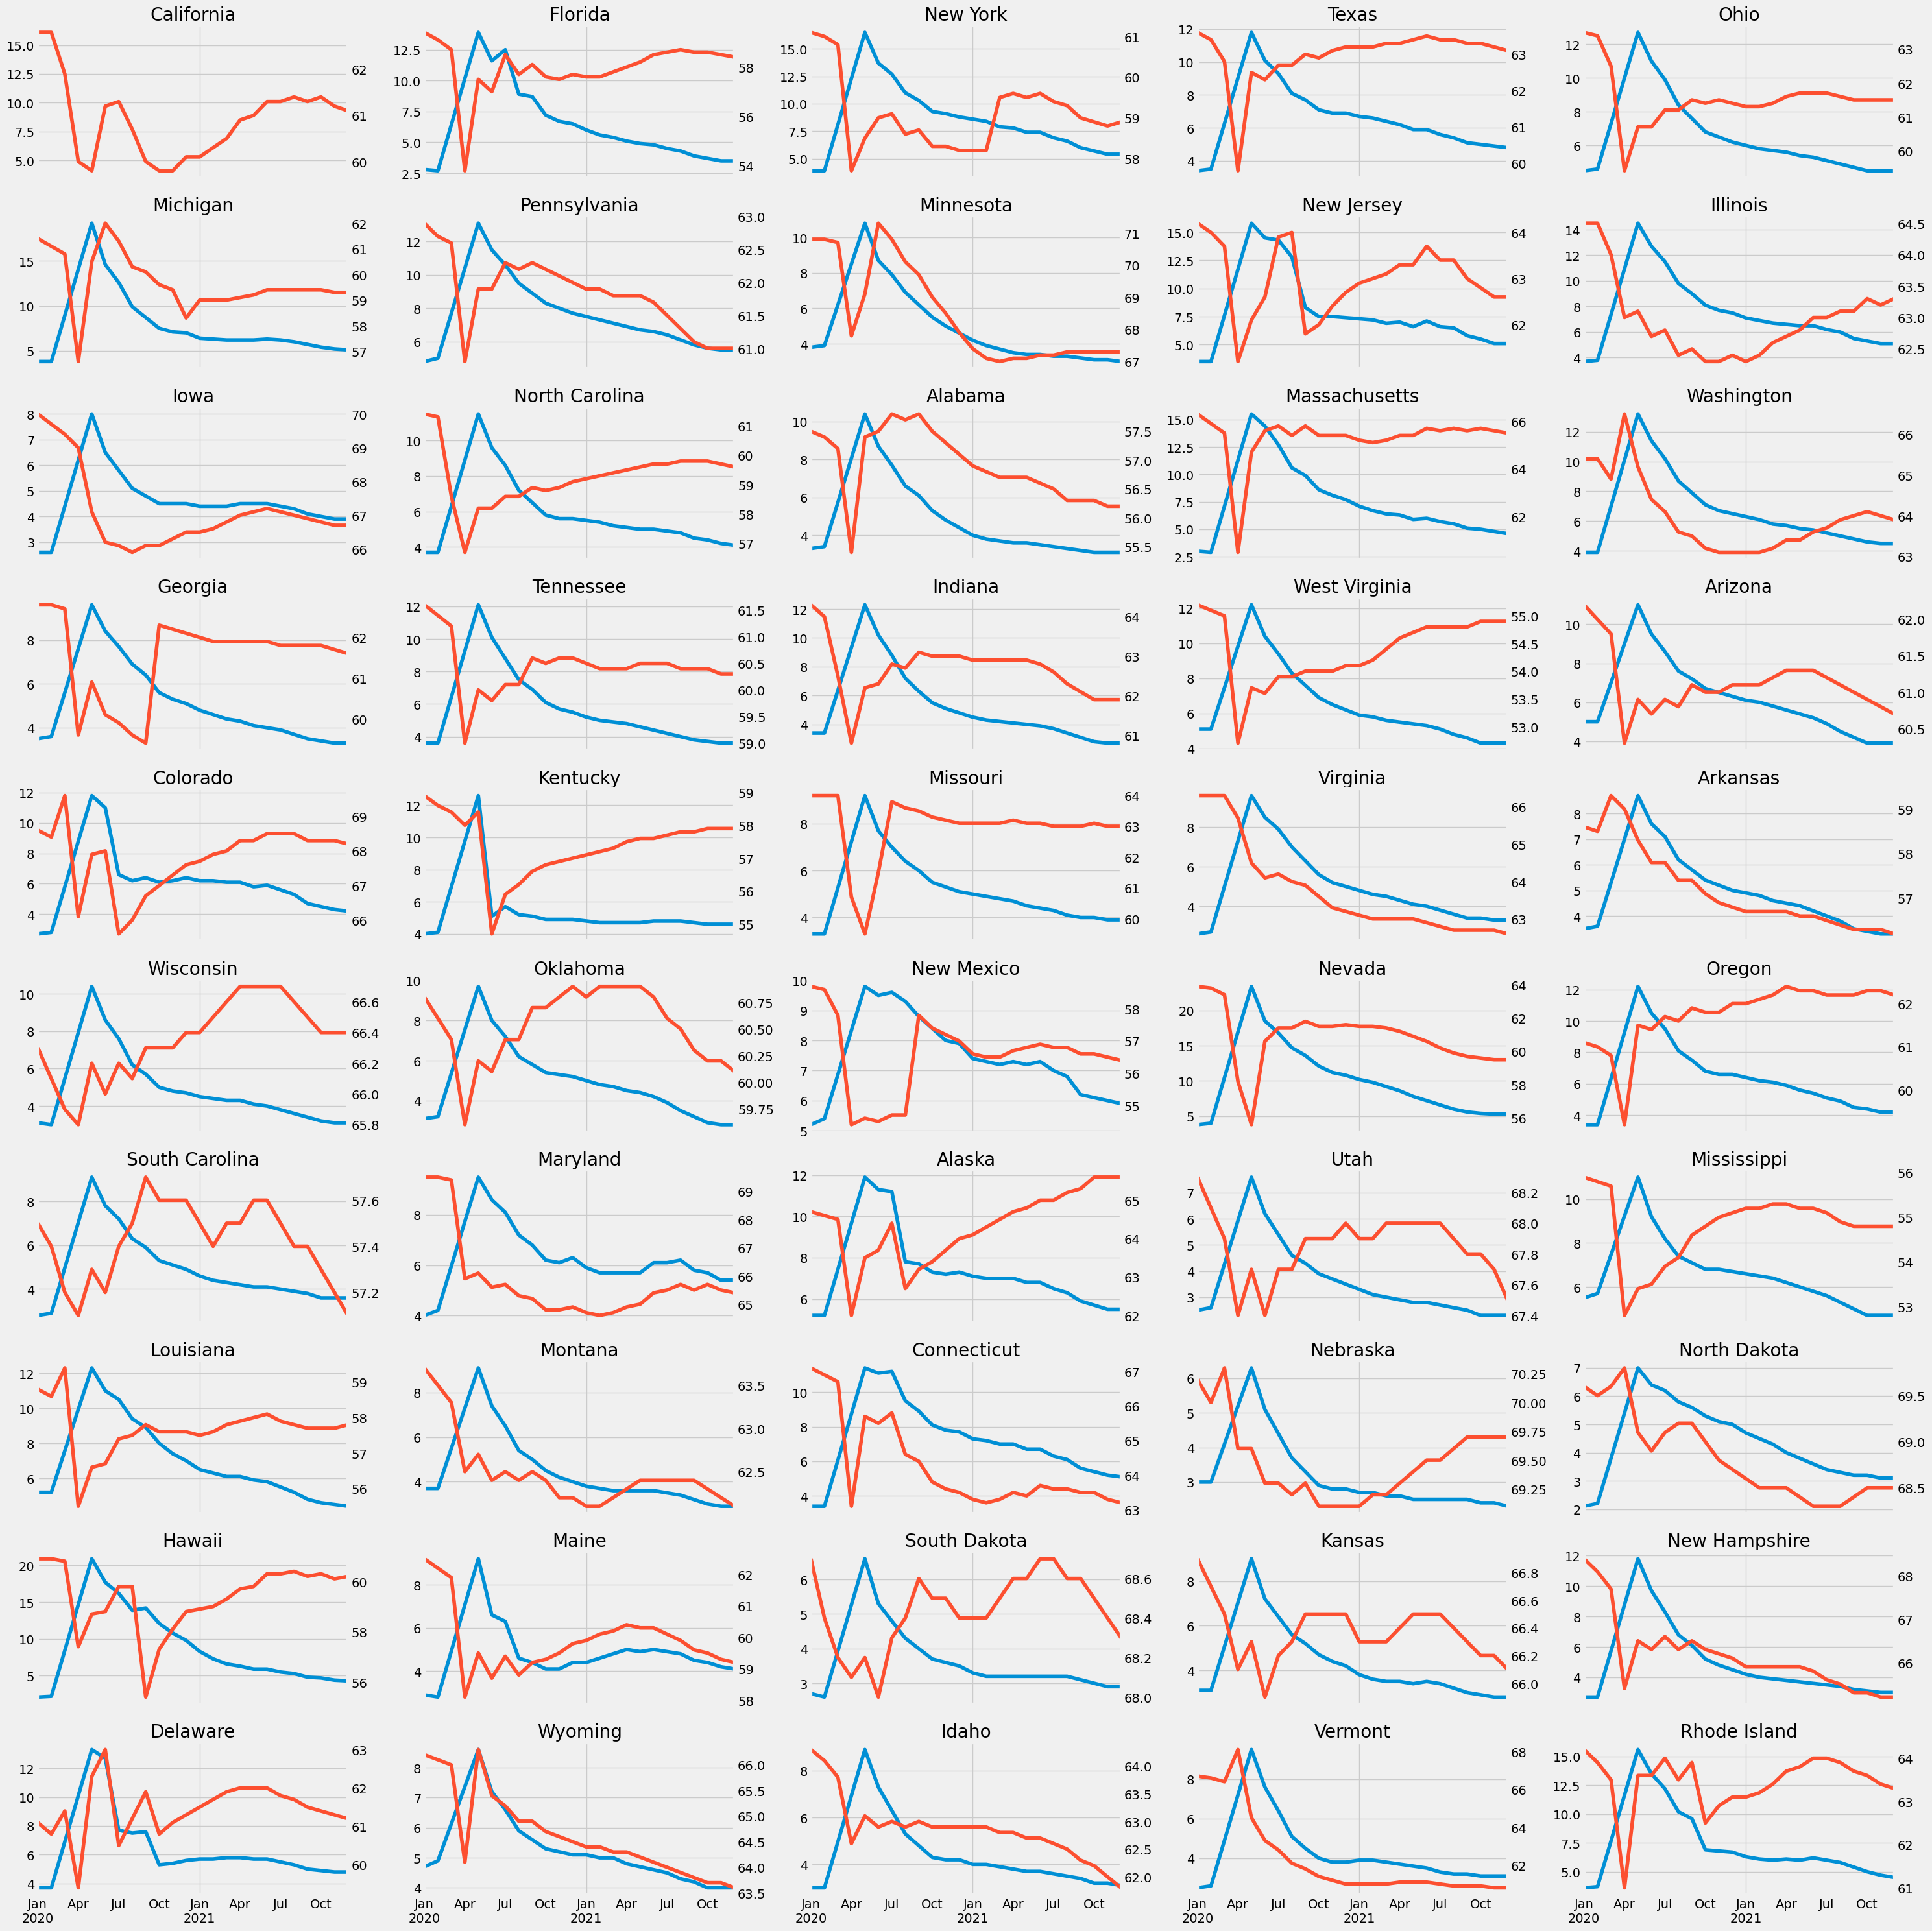

In [39]:
fig, axs = plt.subplots(10, 5, figsize=(30, 30), sharex=True)
axs = axs.flatten()

i = 0
for state in uemp_states.columns:
    if state in ["District Of Columbia","Puerto Rico"]:
        continue
    ax2 = axs[i].twinx()
    uemp_states.query('index >= 2020 and index < 2022')[state] \
        .plot(ax=axs[i], label='Unemployment')
    part_states.query('index >= 2020 and index < 2022')[state] \
        .plot(ax=ax2, label='Participation', color=color_pal[1])
    ax2.grid(False)
    axs[i].set_title(state)
    i += 1
plt.tight_layout()
plt.show()

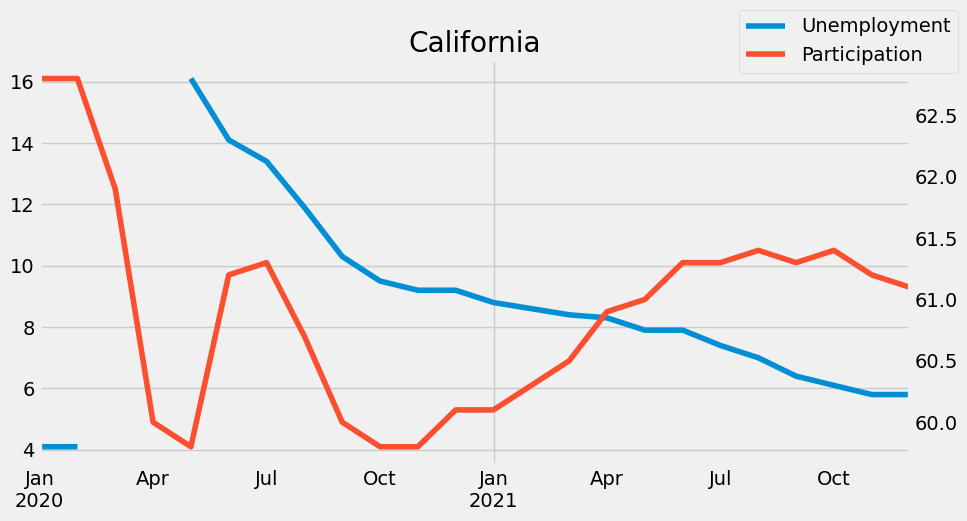

In [40]:
state = 'California'
fig, ax = plt.subplots(figsize=(10, 5), sharex=True)
ax2 = ax.twinx()
uemp_states2 = uemp_states.asfreq('MS')
l1 = uemp_states2.query('index >= 2020 and index < 2022')[state] \
    .plot(ax=ax, label='Unemployment')
l2 = part_states.dropna().query('index >= 2020 and index < 2022')[state] \
    .plot(ax=ax2, label='Participation', color=color_pal[1])
ax2.grid(False)
ax.set_title(state)
fig.legend(labels=['Unemployment','Participation'])
plt.show()